In [1]:
import dask
import fsspec
import glob
# import requests
import datetime
import gc  

import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

from collections import defaultdict
from matplotlib import pyplot as plt
from params import allnames

from dask.diagnostics import progress
from scipy.stats import norm
from tqdm.autonotebook import tqdm
import xml.etree.ElementTree as ET

from params import allnames
from params import homedir
from params import experiment_ids, years, table_ids, labels, variables, savepath

figdir = homedir + 'figures/'


import xml.etree.ElementTree as ET

from dask.diagnostics import progress
from scipy.stats import norm
from tqdm.autonotebook import tqdm

from params import allnames, experiment_ids, variables, years, table_ids, labels
from params import homedir, savepath

## ## style ## ##
xr.set_options(display_style='html')
plt.style.use('science.mplstyle')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False


/glade/scratch/mcowherd/ipykernel_187857/3062428812.py:19: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [45]:
import os
## 
def wrfread(modeldir, gcm, exp, variant, domain, var):
    all_files = sorted(os.listdir(modeldir))
    read_files = []
    for ii in all_files:
        if (
            ii.startswith(var + ".")
            #and gcm in ii
            and variant in ii
            and domain in ii
            and exp in ii
        ):
            if domain in ii:
                read_files.append(os.path.join(modeldir, str(ii)))
    assert len(read_files) > 0, f"No matching files found in {modeldir}"

    del all_files

    data = xr.open_mfdataset(read_files, combine="by_coords")
    var_read = data.variables[var]

    dates = []
    for val in data["day"].data:
        try:
            dates.append(datetime.datetime.strptime(str(val)[0:-2], "%Y%m%d").date())
        except ValueError:
            dates.append(datetime.datetime(int(str(val)[0:4]), int(str(val)[4:6]), 28))


    var_read = xr.DataArray(var_read, dims=["day", "lat2d", "lon2d"])
    var_read["day"] = dates
    return var_read



In [92]:

def get_swei(ds, timename = 'month'):
    swe = ds['snow']
    ntime = swe.shape[0]
    nlat = swe.shape[2]
    nlon = swe.shape[1]
    nyr = int(ntime / 12)
    nd = nlat * nlon
    
    years = np.unique(ds.time.dt.year)
    # Compute the 3-month cumulative sum for each pixel
    if timename == 'month':
        ds_cumsum = ds.rolling(time=3, min_periods=3).sum()
        timeval = np.unique(ds.time.dt.month)
    if timename == 'day':
        ds_cumsum = ds.rolling(time=90, min_periods=90).sum()
        timeval = np.unique(ds.time.dt.dayofyear)
        
    nt = len(np.unique(timeval))

    # Reshape the data back into a 4D array of (year, month, lat, lon)
    ds_new = xr.DataArray(
        ds_cumsum['snow'].data.reshape((-1, nt, ds.sizes['lat'], ds.sizes['lon'])),
        dims=('year', 'month', 'lat', 'lon'),
        coords={'year': years, timename: timeval, 'lat': ds['lat'], 'lon': ds['lon']}
    )
    categ = np.zeros((nyr, nt, nlon, nlat))
    nsample = nyr
    sweix = droughtindx(nsample)  # all values for each pixel.
    sweix = np.array(sweix)

    aindx = np.argsort(ds_new.data, axis=0)

    # Create a broadcasting version of sweix
    sweix_broadcasted = sweix[:, np.newaxis, np.newaxis, np.newaxis]

    # Assign sorted sweix values to categ based on sorted indices (array, indices, values, axis)
    np.put_along_axis(categ, aindx,sweix_broadcasted, axis=0)

    # Create the new xarray Dataset
    ds_swei = xr.Dataset(
        {'swei':(('year','month','lat','lon'), categ)},
        coords={'year': years, timename: timeval,'lat': ds['lat'], 'lon': ds['lon'], }
    )
    return ds_swei

## use this
def get_highest_month(ds,var = 'snow'):
    tmp = ds[var].data.reshape(-1,12,ds[var].shape[1],ds[var].shape[2])
    highest_month = np.argmax(tmp, axis=1)
    coords = {'year': np.unique(ds.time.dt.year), 'lat' : ds.lat, 'lon' : ds.lon}
    data = xr.DataArray(highest_month, dims=('year', 'lat','lon'), coords=coords)
    return data

def convert_year_month(ds,var):
    years = np.unique(ds.time.dt.year)
    months = np.unique(ds.time.dt.month)
    
    data = ds[var].data.reshape(-1,12,ds[var].shape[1],ds[var].shape[2])
    # We then create a new dataset with year, month, lat, lon coordinates
    ds_new = xr.Dataset(
        {
            var: (("year", "month", "lat", "lon"), data),
        },
        coords={
            "year": years,
            "month": months,
            "lat": ds.lat,
            "lon": ds.lon,
        },
    )
    ds_new.attrs = ds.attrs
    return ds_new
    
## use this
def collapse_to_highest_month(ds, var, snw_ds, convert = True):
    highest_month = get_highest_month(snw_ds)
    if convert:
        ds = convert_year_month(ds, var)
    highest_month = highest_month.drop('lat')
    highest_month = highest_month.drop('lon')
    result = ds.sel(month=highest_month, method='nearest').drop('month')
    return result

## usethis
def get_3m_sum(data):
    rolling_sum = data.rolling(time = 3, min_periods=3).sum()
    return rolling_sum

def get_sd_categ(swei, pr, tas, attrs):
    swei_cond = swei < -0.8  # snow drought
    pr_cond = pr < 0  # dry 
    tas_cond = tas > 0  # warm
    
    ds_new = xr.Dataset(
        {
            "swei_cond": (("year", "lat", "lon"), swei_cond.swei.values),
            "pr_cond": (("year", "lat", "lon"), pr_cond.prec.values),
            "tas_cond": (("year", "lat", "lon"), tas_cond.t2.values),
            "swei":  (("year", "lat", "lon"), swei.swei.values),
            "pr" : (("year", "lat", "lon"), pr.prec.values),
            "tas" : (("year", "lat", "lon"), tas.t2.values),
        },
        coords={
            "year": pr.year,
            "lat": pr.lat,
            "lon": pr.lon,
        },
    )
    ds_new.attrs = attrs

    return ds_new

from scipy.stats import norm
def droughtindx(nsample):
    indx = []
    for i in range(nsample):
        ## gringorten plotting position for the range
        px = (i+1-0.44)/(nsample+0.12)
        indx.append(norm.ppf(px))
    return indx


def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
def reshape_3d(ds, var, timename = 'month'):
    # Convert daily data to monthly data by taking the maximum value for each month
    ds_sorted = ds.sortby('time')
    if timename == 'month':
        ds_monthly = ds_sorted.resample(time='1M').max(dim='time')
        # Extract year and month from the time coordinate
        ds_monthly['year'] = ds_monthly['time.year']
        ds_monthly['month'] = ds_monthly['time.month']
        prepend_times = pd.date_range(start='1980-01-31', periods=8, freq='M')
        append_times = pd.date_range(end='2100-10-30', periods=5, freq='M')
        time_dataarray = ds_monthly.time
        prepend_dataarray = xr.DataArray(prepend_times, dims=['time'])
        append_dataarray = xr.DataArray(append_times, dims=['time'])
        time_to_use = xr.concat([prepend_dataarray, time_dataarray, append_dataarray], dim='time')

        month = np.unique(ds_monthly.month.data) #[9,10,11,12,1,  2,  3,  4,  5,  6,  7,  8]
        year = np.unique(ds_monthly.year.data)
        lat = ds_monthly.lat2d.data
        lon = ds_monthly.lon2d.data
        data =ds_monthly[var]
        # Number of layers to add
        n_front_layers = 8
        n_end_layers = 5
        pad_widths = [(n_front_layers, n_end_layers)] + [(0, 0)] * (data.ndim - 1)
        arr_padded = np.pad(data, pad_widths, mode='constant', constant_values=np.nan)

    #reshaped_data = arr_padded.reshape((-1,12,arr_padded.shape[1], arr_padded.shape[2]))
    # Create xarray dataset
    reshaped = xr.Dataset(
        {
            var: (['time', 'lat', 'lon'], arr_padded),
        },
        coords={
            'time': time_to_use,
            'lat': lat,
            'lon': lon,
        },
    )
    return reshaped

In [94]:
import util

domains = ['d01','d02']
variables = ['snow', 't2', 'prec']
gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',]

variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',]
      

calendar = ['365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day','360_day',
             '365_day','proleptic_gregorian', 'proleptic_gregorian',]

ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370']
'''
bcs = ['noBC', 'BC']

domains = ['d03', 'd04']
variables = ['snow', 't2', 'prec']
gcms = ['ec-earth3-veg',]
variants = ['r1i1p1f1',]
calendar = ['proleptic_gregorian']
ssps = ['ssp370']
bcs = ['noBC','BC']

'''
datadir = '/glade/campaign/uwyo/wyom0112/postprocess/'
basedir = '/glade/campaign/uwyo/wyom0112/postprocess/'
savepath = '/glade/campaign/uwyo/wyom0112/berkeley/'

In [150]:

#basedir = '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/'
model = None
n = 0
for domain in domains:
    for idx, gcm in enumerate(gcms[n:]):
        variant = variants[idx+n]

        for bc in bcs:
            if bc == 'BC':
                mod_historical = gcm +'_'+ variant + '_historical_bc'
                mod_future = gcm +'_' + variant+ '_ssp370_bc'
            if bc == 'noBC':
                mod_historical = gcm +'_'+ variant + '_historical'
                mod_future = gcm +'_' + variant+ '_ssp370'
            for var in variables:
                # historical
                model = mod_historical
                datadir = basedir + model + '/postprocess/' + domain + '/'
                date_start_pd, date_end_pd = [1980, 10, 1], [2014, 9, 30]  # 30 years, historical
                exp = "hist"
                var_wrf = wrfread(datadir, model, exp, variant, domain, var)
                var_wrf = util.screen_times_wrf(var_wrf, date_start_pd, date_end_pd)

                # future 
                date_start_pd, date_end_pd = [2013, 10, 1], [2100, 9, 30]
                model = mod_future
                exp = "ssp370"
                datadir = basedir + model + '/postprocess/' + domain + '/'
                var_wrf_ssp370 = wrfread(datadir, model, exp, variant, domain, var)
                var_wrf_ssp370 = util.screen_times_wrf(var_wrf_ssp370, date_start_pd, date_end_pd)
                wrfdata = [var_wrf, var_wrf_ssp370]
                ds_concat = xr.concat(wrfdata, dim = 'day').to_dataset(name = var)
                ds_concat = ds_concat.rename({'day':'time'})
                ds_concat['time'] = ds_concat['time'].astype('datetime64')
                try:
                    ds_concat.to_netcdf(f'{savepath}{var}_{gcms[idx+n]}_{domain}_{bc}.nc')
                    print('saved' + f'{savepath}{var}_{gcms[idx+n]}_{domain}_{bc}.nc')
                except:
                    print('already loaded')

saved/glade/campaign/uwyo/wyom0112/berkeley/snow_cesm2_d01_noBC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/t2_cesm2_d01_noBC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/prec_cesm2_d01_noBC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/snow_cesm2_d01_BC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/t2_cesm2_d01_BC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/prec_cesm2_d01_BC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/snow_mpi-esm1-2-lr_d01_noBC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/t2_mpi-esm1-2-lr_d01_noBC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/prec_mpi-esm1-2-lr_d01_noBC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/snow_mpi-esm1-2-lr_d01_BC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/t2_mpi-esm1-2-lr_d01_BC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/prec_mpi-esm1-2-lr_d01_BC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/snow_cnrm-esm2-1_d01_noBC.nc
saved/glade/campaign/uwyo/wyom0112/berkeley/t2_cnrm-esm2-1_d01_noBC.nc
saved/glade/campaign/uwy

In [95]:
gc.collect()
datasets = {}

for domain in domains:
    for gcm in gcms:
        for bc in bcs:
            filenames = [f"{savepath}{var}_{gcm}_{domain}_{bc}.nc" for var in variables]
            for filename in filenames:
                datasets[filename.split('/')[-1].split('.')[0]] = xr.open_dataset(filename)

datasets_3m_sum = {}
swei_datasets = {}
for name, ds in datasets.items():
    var = name.split('_')[0]
    ds = reshape_3d(ds,var)
    datasets_3m_sum[name] = get_3m_sum(ds)
    if var == 'snow':
        swei_datasets[name] = get_swei(ds, timename = 'month')

datasets_3m_sum_maxsnw = {}
for name, ds in datasets_3m_sum.items():
    var = name.split('_')[0]
    snw_ds = datasets_3m_sum[f'snow_{name.split(f"{var}_")[-1]}']
    datasets_3m_sum_maxsnw[name] = collapse_to_highest_month(ds, var, snw_ds, True)


swei_datasets_maxsnw = {}
for name, ds in swei_datasets.items():
    var = name.split('_')[0]
    snw_long = datasets_3m_sum[f'snow_{name.split(f"{var}_")[-1]}']
    tmp = collapse_to_highest_month(ds, 'swei', snw_long, False)
    tmp.to_netcdf(f'{savepath}swei_max_{name}.nc')
    swei_datasets_maxsnw[f'{name}'] = tmp
    
categs = {}
for name, swei in swei_datasets_maxsnw.items():
    var = name.split('_')[0]
    
    pr_long = datasets_3m_sum_maxsnw[f'prec_{name.split(f"{var}_")[-1]}']
    pr_anom = pr_long - pr_long.sel(year=slice(pr_long.year[0], pr_long.year[49])).mean(dim='year') ## val minus average

    tas_long = datasets_3m_sum_maxsnw[f't2_{name.split(f"{var}_")[-1]}']
    tas_anom = tas_long - tas_long.sel(year=slice(tas_long.year[0], tas_long.year[49])).mean(dim='year') ## val minus average

    tmp = get_sd_categ(swei, pr_anom ,tas_anom, pr_long.attrs)
    try:
        tmp.to_netcdf(f'{savepath}categs_{name}.nc')
        print('saved ' + f'{savepath}categs_{name}.nc')
    except:
        continue
    categs[name] = tmp

saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_cesm2_d01_noBC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_cesm2_d01_BC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_mpi-esm1-2-lr_d01_noBC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_mpi-esm1-2-lr_d01_BC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_cnrm-esm2-1_d01_noBC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_cnrm-esm2-1_d01_BC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_ec-earth3-veg_d01_noBC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_ec-earth3-veg_d01_BC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_fgoals-g3_d01_noBC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_fgoals-g3_d01_BC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_ukesm1-0-ll_d01_noBC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/categs_snow_ukesm1-0-ll_d01_BC.nc
saved /glade/campaign/uwyo/wyom0112/berkeley/cat

In [104]:
tmp = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/categs_snow_ukesm1-0-ll_d02_BC.nc')

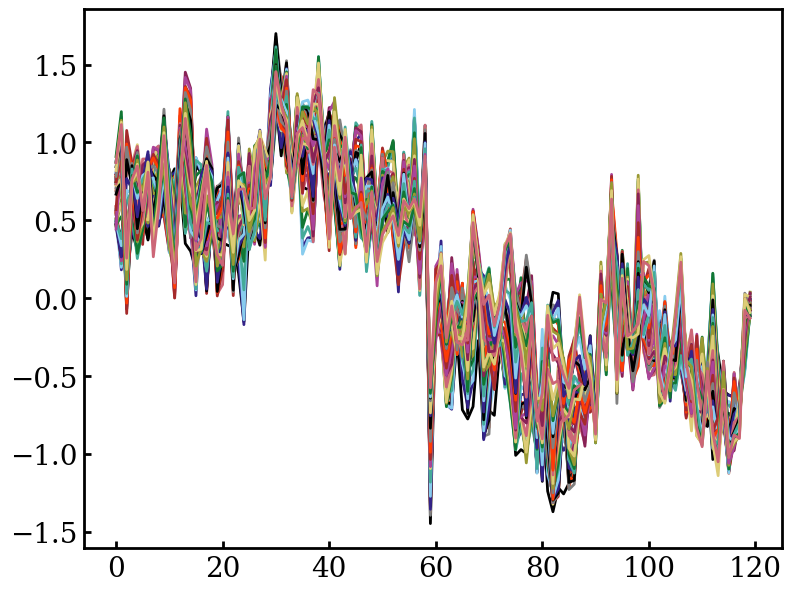

In [106]:
fig,ax =plt.subplots()
for i in range(60):
    ax.plot(np.nanmean(tmp['swei'][1:, i*3:i*3+3:], axis = (1,2)))
plt.show()

In [ ]:
fig,ax =plt.subplots()
for i in range(60):
    ax.plot(np.nanmean(tmp['swei'][1:, i*3:i*3+3:], axis = (1,2)))
plt.show()

In [76]:
roll = ds.rolling(time=3, min_periods=3).sum()

<xarray.Dataset>
Dimensions:  (time: 1451, lat: 492, lon: 243)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-09-30
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 484 485 486 487 488 489 490 491
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 235 236 237 238 239 240 241 242
Data variables:
    snow     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [6]:
grid_dataBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d03_BC.nc')
tmpBC = grid_dataBC.groupby(grid_dataBC.time.dt.year).max()
grid_datanoBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d03_noBC.nc')
tmpnoBC = grid_datanoBC.groupby(grid_datanoBC.time.dt.year).max()
mask = np.nansum(tmpBC['snow'][0:30], axis = (0)) > 100

In [4]:
import geopandas as gpd
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{projectdir}/fos-data/spatialdata/huc2.shp')
huc6 = gpd.read_file(f'{projectdir}/fos-data/spatialdata/huc6.shp')
metapath = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'
coords1 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d01')
coords2 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d02')
coords4 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d04')
coords3 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d03')

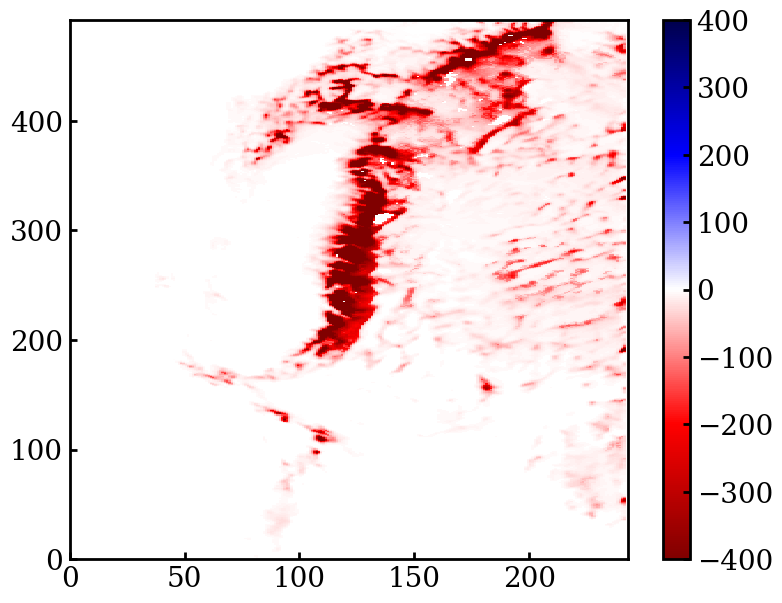

In [7]:
basemap = np.nanmean(tmpBC['snow'][0:30,:,:], axis = 0)
map2 = np.nanmean(tmpBC['snow'][90:,:,:], axis=0)
plotmeBC = map2 - basemap
plotmeBC[~mask] = np.nan
plt.pcolormesh(plotmeBC, cmap = 'seismic_r', vmin = -400, vmax = 400)
plt.colorbar()

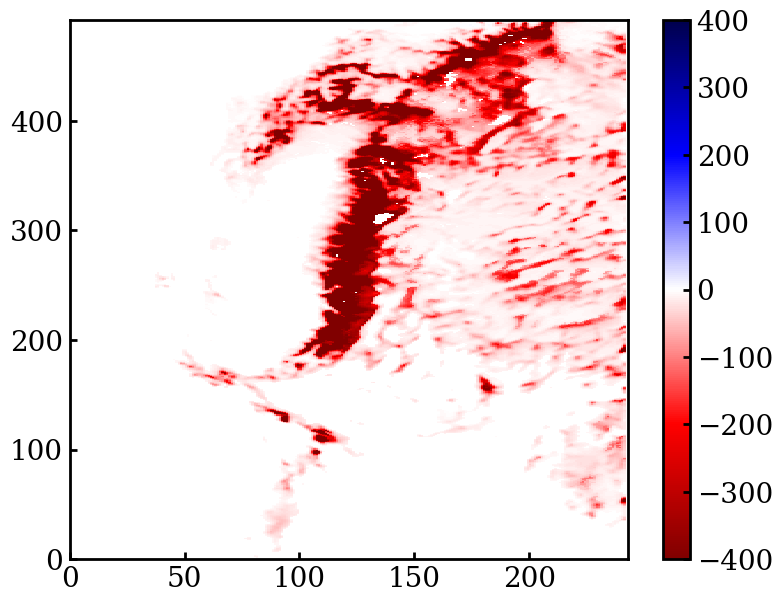

In [8]:
basemap = np.nanmean(tmpnoBC['snow'][0:30,:,:], axis = 0)
map2 = np.nanmean(tmpnoBC['snow'][90:,:,:], axis=0)
plotmenoBC = map2 - basemap
plotmenoBC[~mask] = np.nan

plt.pcolormesh(plotmenoBC, cmap = 'seismic_r', vmin = -400, vmax = 400)
plt.colorbar()

2070

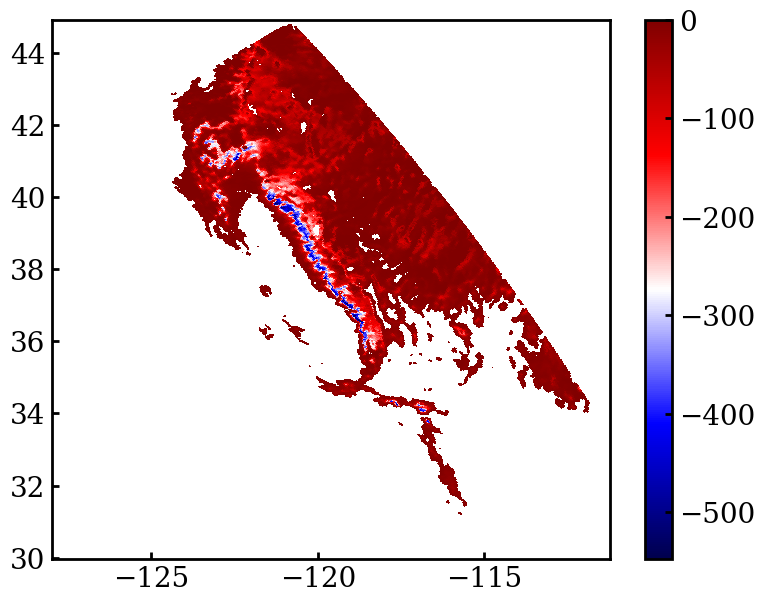

In [9]:
fig,ax = plt.subplots()
cbobj = ax.pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0], plotmenoBC - plotmeBC, 
              cmap = 'seismic', vmax = 0)
plt.colorbar(cbobj)
plt.show()

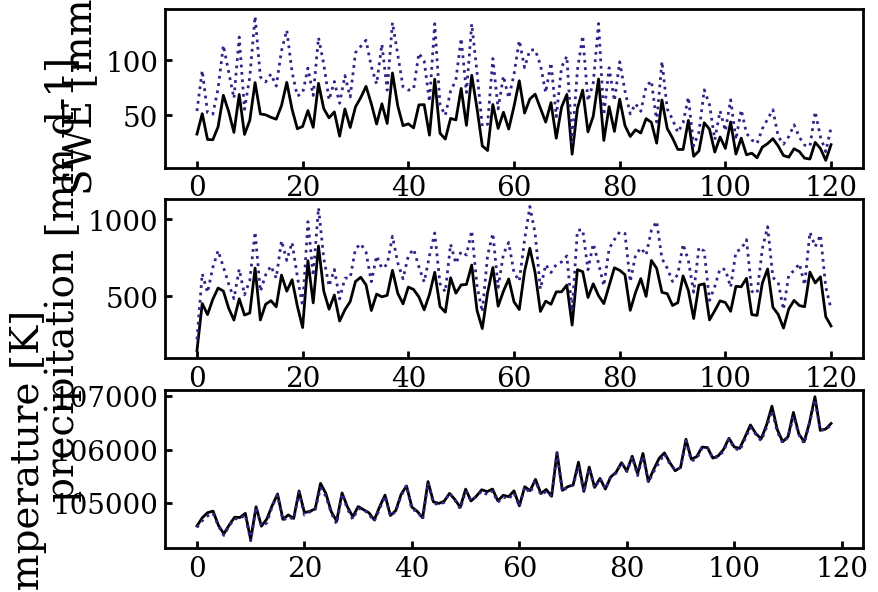

In [36]:
fig,ax = plt.subplots(3,1)
ax[0].plot(np.nanmean(tmpBC['snow'], axis = (1,2)), '-')
ax[0].plot(np.nanmean(tmpnoBC['snow'], axis = (1,2)), ':')
ax[0].set_ylabel('SWE [mm]')

ax[1].plot(np.nanmean(precBC['prec'], axis = (1,2)))
ax[1].plot(np.nanmean(precnoBC['prec'], axis = (1,2)),':')
ax[1].set_ylabel('precipitation [mm d-1]')

ax[2].plot(np.nanmean(t2BC['t2'][1:-1], axis = (1,2)))
ax[2].plot(np.nanmean(t2noBC['t2'][1:-1], axis = (1,2)),':')
ax[2].set_ylabel('temperature [K]')
plt.show()

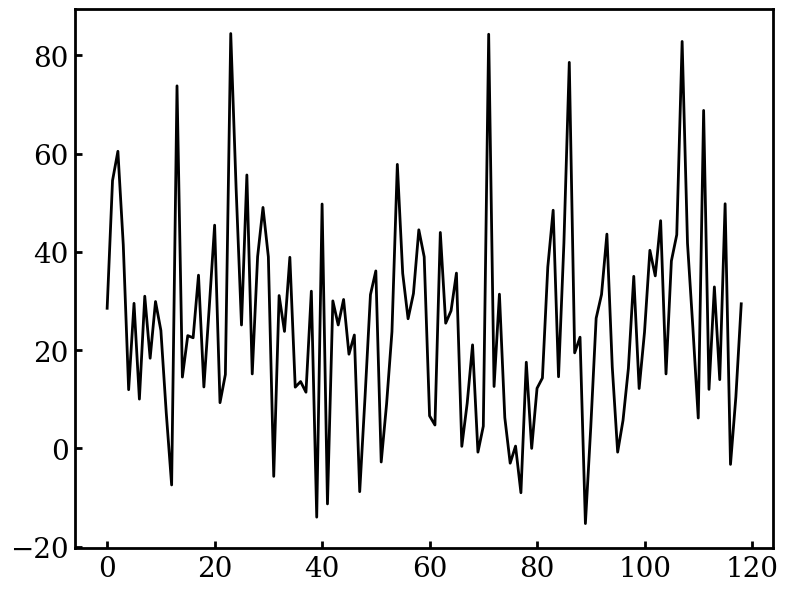

In [35]:
plt.plot(np.nanmean(t2BC['t2'][1:-1], axis = (1,2)) - np.nanmean(t2noBC['t2'][1:-1], axis = (1,2)))


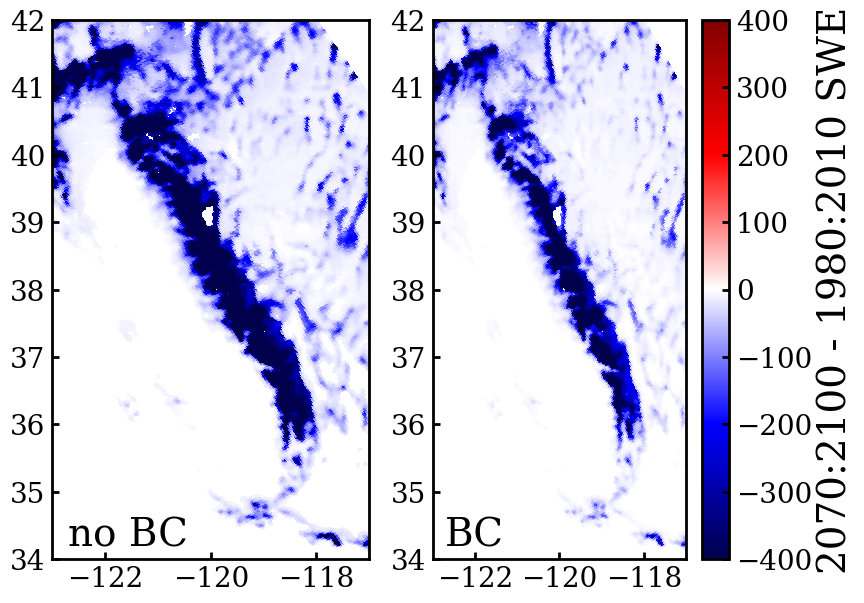

In [11]:
grid_dataBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d03_BC.nc')
tmpBC = grid_dataBC.groupby(grid_dataBC.time.dt.year).max()
grid_datanoBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d03_noBC.nc')
tmpnoBC = grid_datanoBC.groupby(grid_datanoBC.time.dt.year).max()
basemap = np.nanmean(tmpBC['snow'][0:30,:,:], axis = 0)
map2 = np.nanmean(tmpBC['snow'][90:,:,:], axis=0)
plotmeBC = map2 - basemap
plotmeBC[~mask] = np.nan
basemap = np.nanmean(tmpnoBC['snow'][0:30,:,:], axis = 0)
map2 = np.nanmean(tmpnoBC['snow'][90:,:,:], axis=0)
plotmenoBC = map2 - basemap
plotmenoBC[~mask] = np.nan


fig,ax = plt.subplots(1,2)
data = [plotmenoBC, plotmeBC]
for i, bc in enumerate(['noBC', 'BC']):
    d3data = data[i]
    cbobj = ax[i].pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0],d3data , 
              cmap = 'seismic',vmin = -400, vmax = 400)
    ax[i].set_xlim((-123, -117))
    ax[i].set_ylim((34,42))
ax[0].text(-122.7,34.2, 'no BC')
ax[1].text(-122.7,34.2, 'BC')

plt.colorbar(cbobj, label = '2070:2100 - 1980:2010 SWE')
plt.show()      

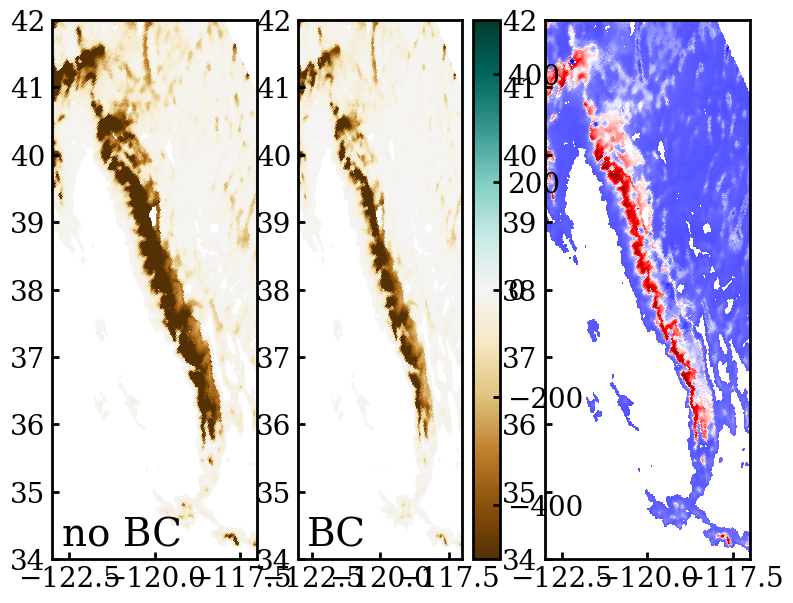

In [32]:

fig,ax = plt.subplots(1,3)
data = [plotmenoBC, plotmeBC]
for i, bc in enumerate(['noBC', 'BC']):
    d3data = data[i]
    cbobj = ax[i].pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0],d3data , 
              cmap = 'BrBG',vmin = -500, vmax = 500)
    ax[i].set_xlim((-123, -117))
    ax[i].set_ylim((34,42))
ax[0].text(-122.7,34.2, 'no BC')
ax[1].text(-122.7,34.2, 'BC')

plt.colorbar(cbobj) # , label = '2070:2100 - 1980:2010 SWE')
ax[2].pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0],plotmeBC-plotmenoBC,cmap = 'seismic') 
ax[2].set_xlim((-123, -117))
ax[2].set_ylim((34,42))
plt.show()      

In [12]:
grid_dataBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/prec_ec-earth3-veg_d03_BC.nc')
precBC = grid_dataBC.groupby(grid_dataBC.time.dt.year).sum()
grid_datanoBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/prec_ec-earth3-veg_d03_noBC.nc')
precnoBC = grid_datanoBC.groupby(grid_datanoBC.time.dt.year).sum()
basemap = np.nanmean(precBC['prec'][0:30,:,:], axis = 0)
map2 = np.nanmean(precBC['prec'][90:,:,:], axis=0)
plotprecBC = map2 - basemap
plotprecBC[~mask] = np.nan
basemap = np.nanmean(precnoBC['prec'][0:30,:,:], axis = 0)
map2 = np.nanmean(precnoBC['prec'][90:,:,:], axis=0)
plotprecnoBC = map2 - basemap
plotprecnoBC[~mask] = np.nan

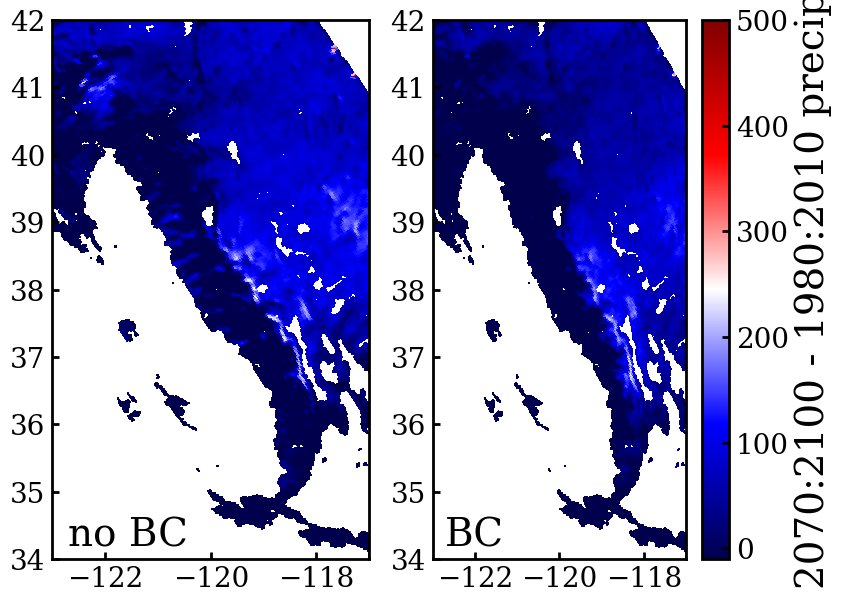

In [13]:
fig,ax = plt.subplots(1,2)
data = [plotprecnoBC, plotprecBC]
for i, bc in enumerate(['noBC', 'BC']):
    d3data = data[i]
    cbobj = ax[i].pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0],d3data , 
              cmap = 'seismic', vmin = -10, vmax = 500)
    ax[i].set_xlim((-123, -117))
    ax[i].set_ylim((34,42))
ax[0].text(-122.7,34.2, 'no BC')
ax[1].text(-122.7,34.2, 'BC')

plt.colorbar(cbobj, label = '2070:2100 - 1980:2010 precip')
plt.show()      

In [14]:
grid_dataBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/t2_ec-earth3-veg_d03_BC.nc')
t2BC = grid_dataBC.groupby(grid_dataBC.time.dt.year).sum()
grid_datanoBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/t2_ec-earth3-veg_d03_noBC.nc')
t2noBC = grid_datanoBC.groupby(grid_datanoBC.time.dt.year).sum()
basemap = np.nanmean(t2BC['t2'][0:30,:,:], axis = 0)
map2 = np.nanmean(t2BC['t2'][90:,:,:], axis=0)
plott2BC = map2 - basemap
plott2BC[~mask] = np.nan
basemap = np.nanmean(t2noBC['t2'][0:30,:,:], axis = 0)
map2 = np.nanmean(t2noBC['t2'][90:,:,:], axis=0)
plott2noBC = map2 - basemap
plott2noBC[~mask] = np.nan

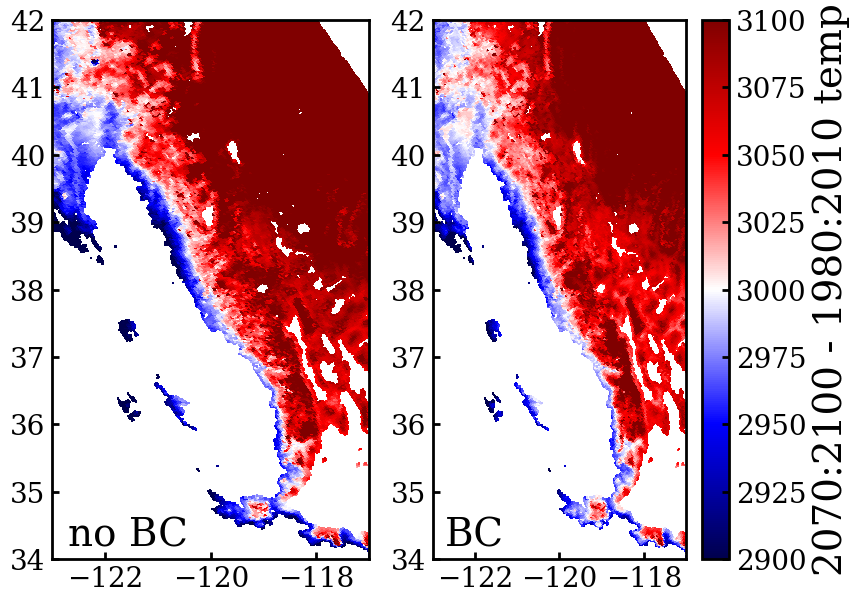

In [19]:
fig,ax = plt.subplots(1,2)
data = [plott2noBC, plott2BC]
for i, bc in enumerate(['noBC', 'BC']):
    d3data = data[i]
    cbobj = ax[i].pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0],d3data , 
              cmap = 'seismic', vmin = 2900, vmax = 3100)
    ax[i].set_xlim((-123, -117))
    ax[i].set_ylim((34,42))
ax[0].text(-122.7,34.2, 'no BC')
ax[1].text(-122.7,34.2, 'BC')

plt.colorbar(cbobj, label = '2070:2100 - 1980:2010 temp')
plt.show()      

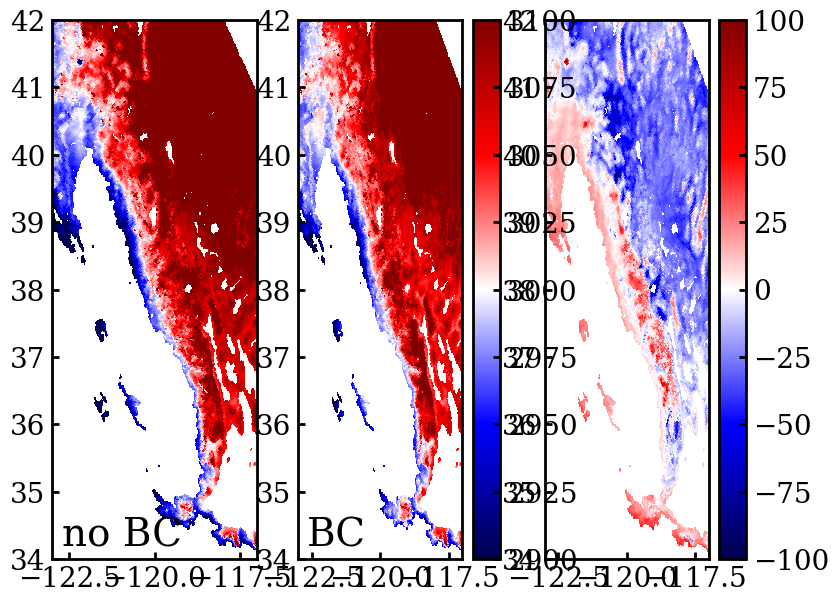

In [41]:
fig,ax = plt.subplots(1,3)
data = [plott2noBC, plott2BC]
for i, bc in enumerate(['noBC', 'BC']):
    d3data = data[i]
    cbobj = ax[i].pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0],d3data , 
              cmap = 'seismic', vmin = 2900, vmax = 3100)
    ax[i].set_xlim((-123, -117))
    ax[i].set_ylim((34,42))
ax[0].text(-122.7,34.2, 'no BC')
ax[1].text(-122.7,34.2, 'BC')
plt.colorbar(cbobj) # , label = '2070:2100 - 1980:2010 SWE')
cb2 = ax[2].pcolormesh(coords3['XLONG'][0], coords3['XLAT'][0],plott2BC-plott2noBC,cmap = 'seismic', vmin = -100, vmax = 100) 
plt.colorbar(cb2) # , label = '2070:2100 - 1980:2010 SWE')

ax[2].set_xlim((-123, -117))
ax[2].set_ylim((34,42))
plt.show()      


(array([5.0000e+00, 1.0000e+01, 5.4000e+01, 2.0900e+02, 5.3200e+02,
        8.1300e+02, 1.3080e+03, 2.0220e+03, 3.7770e+03, 2.0352e+04]),
 array([-1626.37512207, -1464.36889648, -1302.3626709 , -1140.35656738,
         -978.3503418 ,  -816.34411621,  -654.33789062,  -492.33169556,
         -330.32550049,  -168.31930542,    -6.31309509]),
 <BarContainer object of 10 artists>)

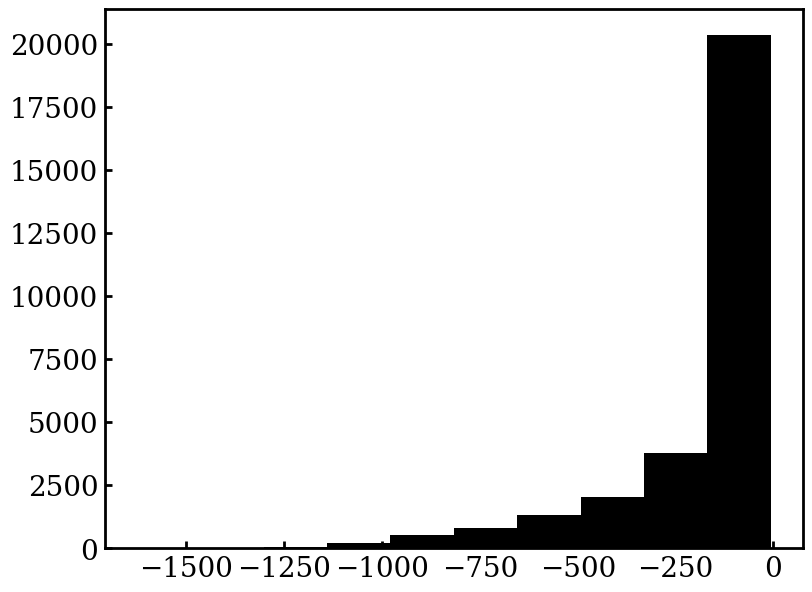

In [68]:
plt.hist(plotme.flatten())

472704

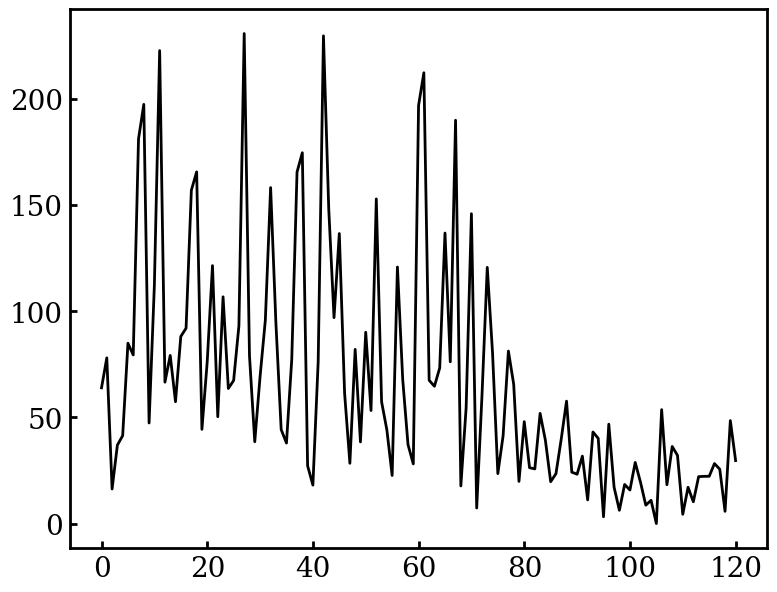

In [29]:
plt.plot(tmp['snow'][:,125,230])